Iñigo Martin Melero

## Participante 23

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_23_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


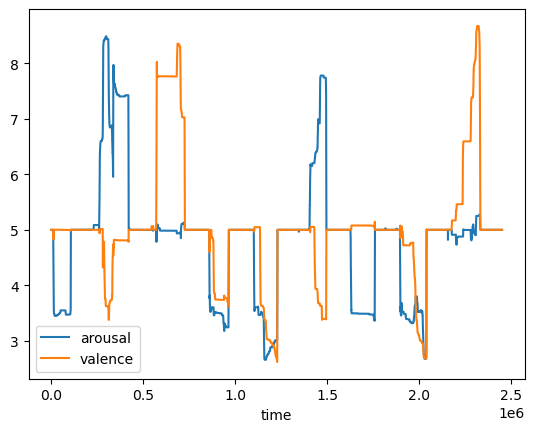

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_23_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.895  36.322  17.545  32.856  26.080     6.426     6.876   
1              1  0.892  36.399  17.494  32.866  26.090     6.426     7.000   
2              2  0.886  36.016  17.490  32.847  26.077     6.304     6.879   
3              3  0.882  36.175  17.478  32.837  26.076     6.343     6.918   
4              4  0.889  36.331  17.517  32.875  26.083     6.506     7.000   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.557  34.955  15.743  32.043  23.696     4.660     5.317   
2451580  2451580  0.560  35.005  15.782  32.024  23.700     4.741     5.317   
2451581  2451581  0.557  34.564  15.806  32.034  23.693     4.661     5.276   
2451582  2451582  0.557  34.732  15.646  32.062  23.696     4.782     5.316   
2451583  2451583  0.589  34.897  15.789  32.063  23.710     4.864     5.398   

         emg_trap  video  
0          15.788     10

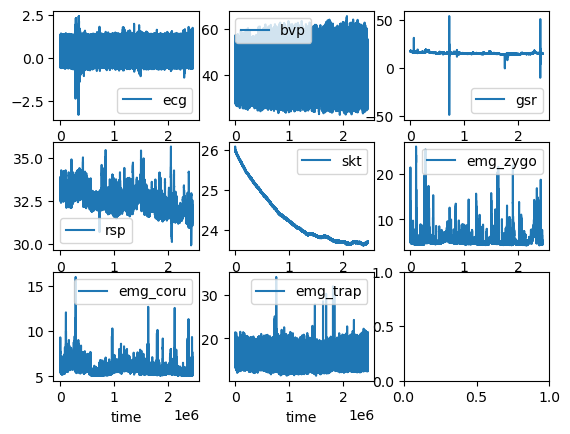

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

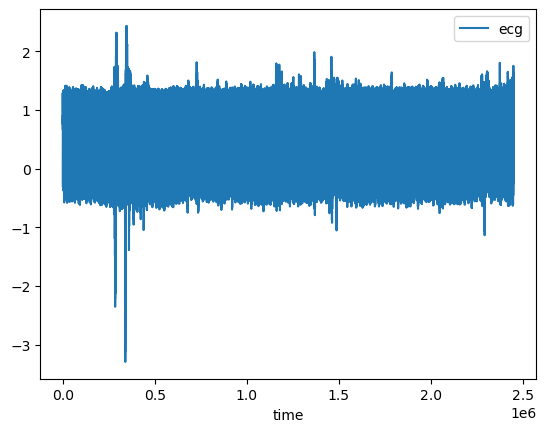

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

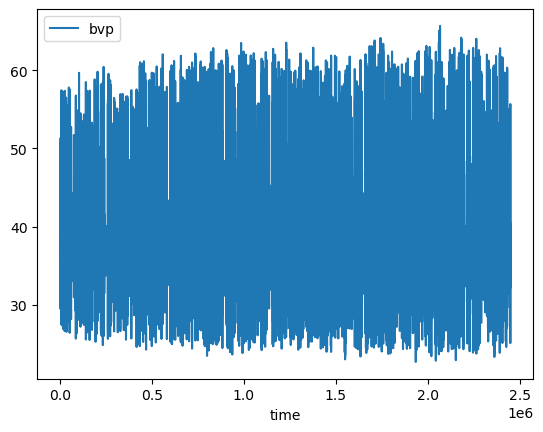

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

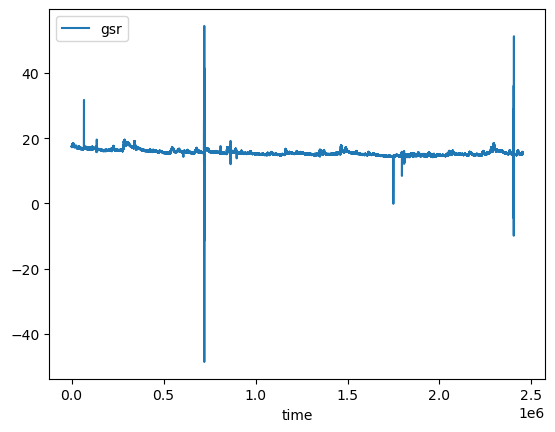

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

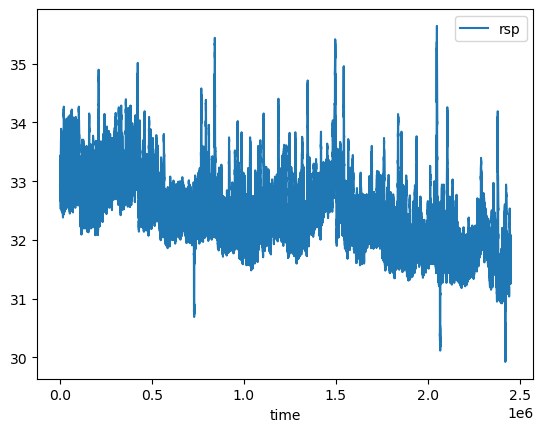

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

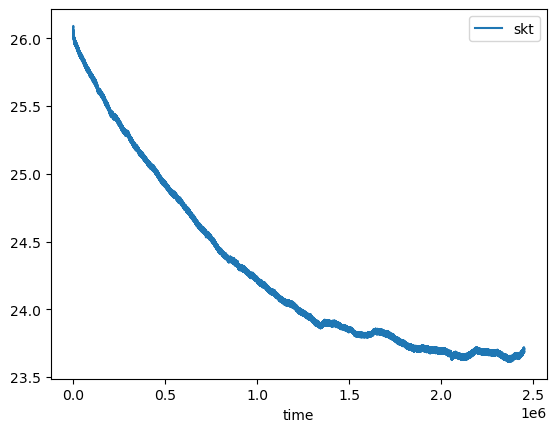

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

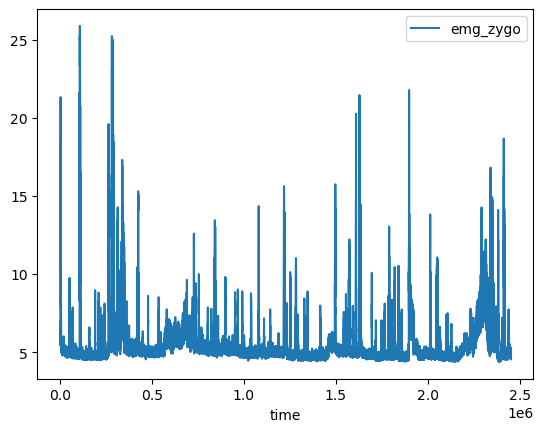

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

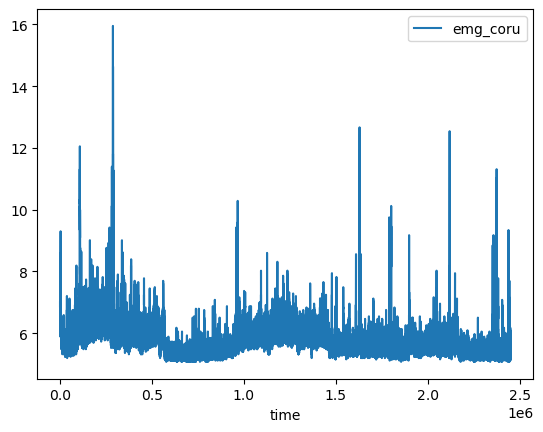

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

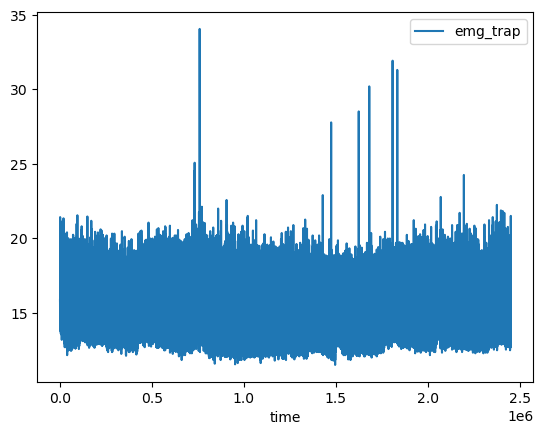

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

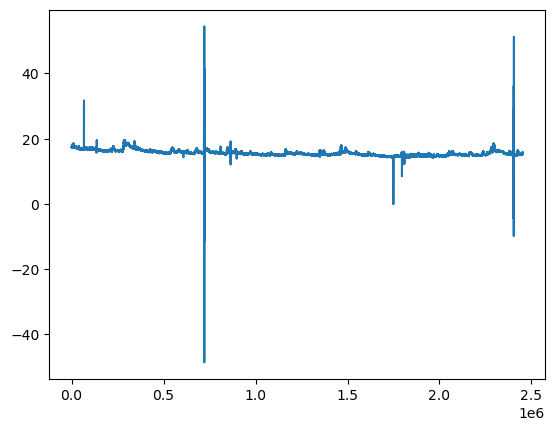

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

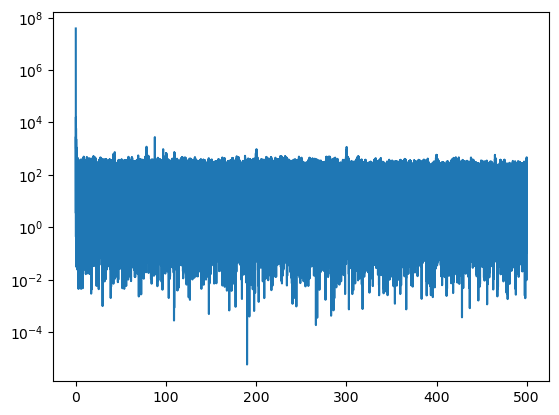

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

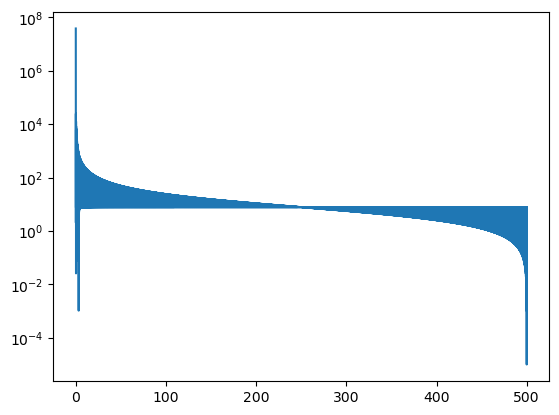

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

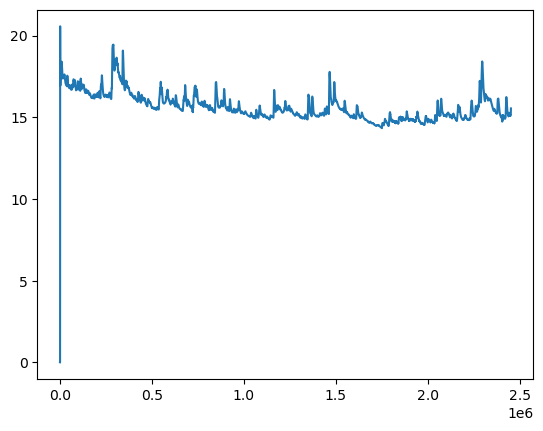

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  15.535
2451580  15.535
2451581  15.536
2451582  15.536
2451583  15.537

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

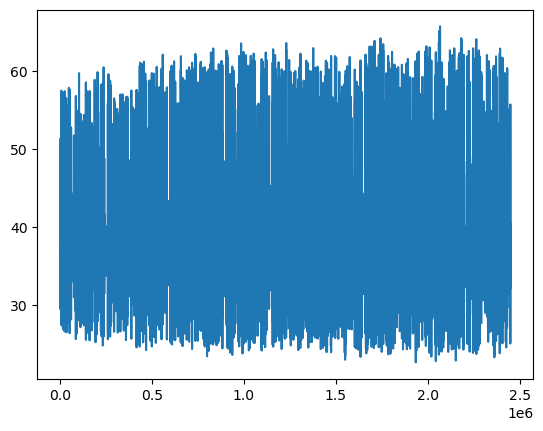

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

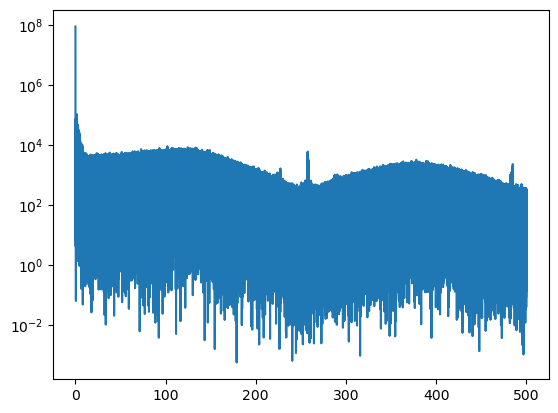

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

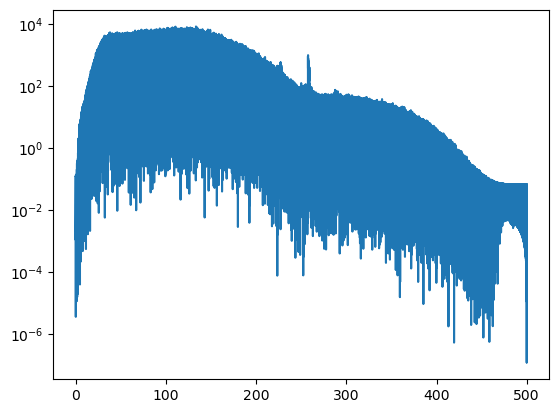

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

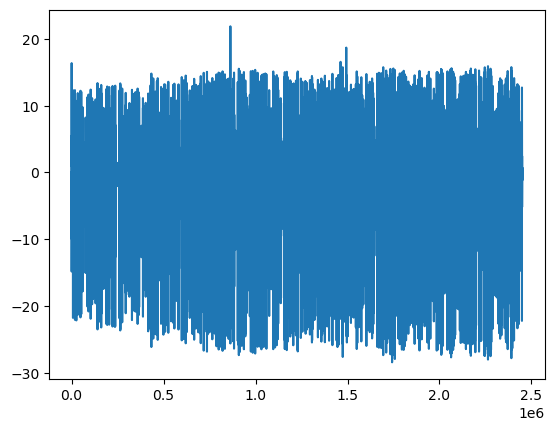

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.009
1        42.633
2        50.248
3        53.353
4        46.086
...         ...
2451579  36.995
2451580  36.948
2451581  36.964
2451582  36.977
2451583  36.916

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

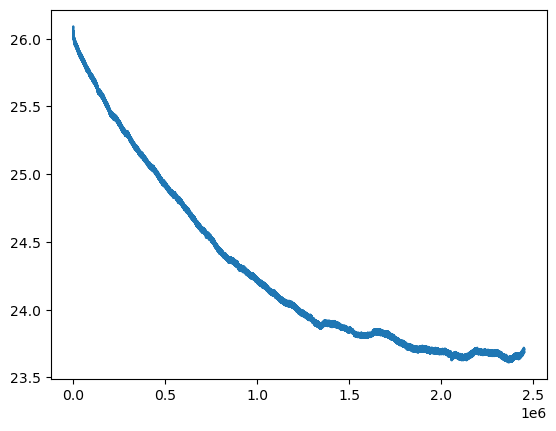

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

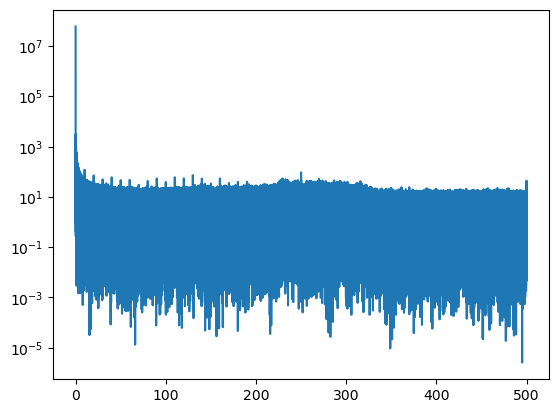

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

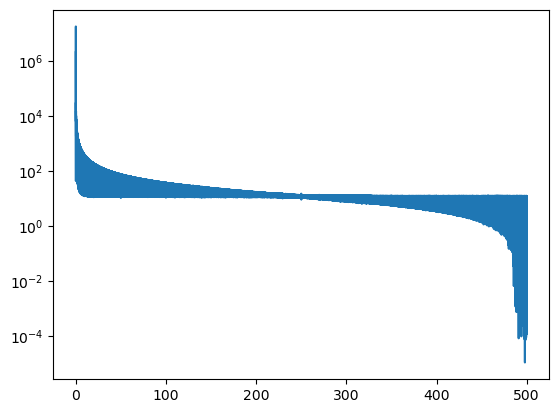

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

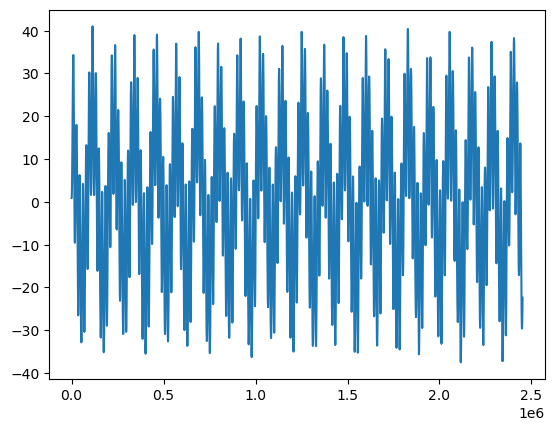

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.836
1        40.836
2        40.836
3        40.836
4        40.836
...         ...
2451579  17.539
2451580  17.543
2451581  17.547
2451582  17.552
2451583  17.556

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.895  32.856     6.426     6.876    15.788     10
1              1  0.892  32.866     6.426     7.000    15.911     10
2              2  0.886  32.847     6.304     6.879    15.872     10
3              3  0.882  32.837     6.343     6.918    15.790     10
4              4  0.889  32.875     6.506     7.000    15.911     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.557  32.043     4.660     5.317    14.023     12
2451580  2451580  0.560  32.024     4.741     5.317    14.023     12
2451581  2451581  0.557  32.034     4.661     5.276    13.942     12
2451582  2451582  0.557  32.062     4.782     5.316    14.022     12
2451583  2451583  0.589  32.063     4.864     5.398    14.064     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.895  32.856     6.426     6.876    15.788     10  38.009   
1              1  0.892  32.866     6.426     7.000    15.911     10  42.633   
2              2  0.886  32.847     6.304     6.879    15.872     10  50.248   
3              3  0.882  32.837     6.343     6.918    15.790     10  53.353   
4              4  0.889  32.875     6.506     7.000    15.911     10  46.086   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.557  32.043     4.660     5.317    14.023     12  36.995   
2451580  2451580  0.560  32.024     4.741     5.317    14.023     12  36.948   
2451581  2451581  0.557  32.034     4.661     5.276    13.942     12  36.964   
2451582  2451582  0.557  32.062     4.782     5.316    14.022     12  36.977   
2451583  2451583  0.589  32.063     4.864     5.398    14.064     12  36.916   

            gsr     skt  
0         0.000  40.836  
1         0.000  40.836  
2         0.000  40.836  
3         0.000  40.836  
4         0.000  40.836  
...         ...     ...  
2451579  15.535  17.539  
2451580  15.535  17.543  
2451581  15.536  17.547  
2451582  15.536  17.552  
2451583  15.537  17.556  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.725162  0.565455  0.488663  0.785466  0.661080  0.019694   
221502    221502  0.724114  0.566231  0.488663  0.785400  0.666667  0.023537   
221503    221503  0.721844  0.565534  0.488663  0.785320  0.663873  0.019694   
221504    221504  0.720622  0.564439  0.488858  0.785254  0.663873  0.023537   
221505    221505  0.721145  0.564937  0.488858  0.785174  0.657976  0.025555   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.688493  0.563842  0.355942  0.351991  0.306021  0.114276   
2331580  2331580  0.688493  0.565673  0.355942  0.352071  0.291434  0.110433   
2331581  2331581  0.686747  0.565017  0.355942  0.352150  0.288330  0.112355   
2331582  2331582  0.686223  0.562947  0.355942  0.352230  0.291434  0.108464   
2331583  2331583  0.685001  0.562270  0.355942  0.352310  0.297331  0.106446   

         emg_coru  emg_trap  video  
221501   0.147072  0.109928      7  
221502   0.158287  0.116457      7  
221503   0.150933  0.116511      7  
221504   0.150841  0.118651      7  
221505   0.154610  0.118705      7  
...           ...       ...    ...  
2331579  0.026197  0.103291      2  
2331580  0.018844  0.098956      2  
2331581  0.022429  0.092374      2  
2331582  0.015075  0.090126      2  
2331583  0.018660  0.092320      2  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.725162  0.565455  0.488663  0.661080  0.785466  0.019694   
221502    221502  0.724114  0.566231  0.488663  0.666667  0.785400  0.023537   
221503    221503  0.721844  0.565534  0.488663  0.663873  0.785320  0.019694   
221504    221504  0.720622  0.564439  0.488858  0.663873  0.785254  0.023537   
221505    221505  0.721145  0.564937  0.488858  0.657976  0.785174  0.025555   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.688493  0.563842  0.355942  0.306021  0.351991  0.114276   
2331580  2331580  0.688493  0.565673  0.355942  0.291434  0.352071  0.110433   
2331581  2331581  0.686747  0.565017  0.355942  0.288330  0.352150  0.112355   
2331582  2331582  0.686223  0.562947  0.355942  0.291434  0.352230  0.108464   
2331583  2331583  0.685001  0.562270  0.355942  0.297331  0.352310  0.106446   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
221540   0.723415  0.564240  0.489836  0.663873  0.782506  0.019694  0.154702   
221560   0.718352  0.526383  0.490422  0.654873  0.780993  0.023585  0.120783   
221580   0.717828  0.555602  0.490813  0.651769  0.779466  0.021616  0.116831   
221600   0.714859  0.570709  0.491400  0.666977  0.777940  0.021664  0.116923   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.712589  0.564439  0.355747  0.297331  0.345514  0.098521  0.026197   
2331520  0.706827  0.564599  0.355747  0.279640  0.347146  0.084830  0.015167   
2331540  0.702811  0.565773  0.355747  0.291434  0.348792  0.090643  0.022429   
2331560  0.695303  0.566211  0.355942  0.291434  0.350425  0.082813  0.018752   
2331580  0.688493  0.565673  0.355942  0.291434  0.352071  0.110433  0.018844   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
1      0.723415  0.564240  0.489836  0.663873  0.782506  0.019694  0.154702   
2      0.718352  0.526383  0.490422  0.654873  0.780993  0.023585  0.120783   
3      0.717828  0.555602  0.490813  0.651769  0.779466  0.021616  0.116831   
4      0.714859  0.570709  0.491400  0.666977  0.777940  0.021664  0.116923   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.712589  0.564439  0.355747  0.297331  0.345514  0.098521  0.026197   
63500  0.706827  0.564599  0.355747  0.279640  0.347146  0.084830  0.015167   
63501  0.702811  0.565773  0.355747  0.291434  0.348792  0.090643  0.022429   
63502  0.695303  0.566211  0.355942  0.291434  0.350425  0.082813  0.018752   
63503  0.688493  0.565673  0.355942  0.291434  0.352071  0.110433  0.018844   

       emg_trap  valence  arousal  
0      0.103291    5.000    5.000  
1      0.107733    5.000    5.000  
2      0.090233    5.000    5.000  
3      0.114263    5.000    5.000  
4      0.125341    5.000    5.000  
...         ...      ...      ...  
63499  0.098849    7.168    5.277  
63500  0.090179    7.152    5.277  
63501  0.085630    7.136    5.276  
63502  0.116511    7.120    5.275  
63503  0.098956    7.105    5.274  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
1      0.723415  0.564240  0.489836  0.663873  0.782506  0.019694  0.154702   
2      0.718352  0.526383  0.490422  0.654873  0.780993  0.023585  0.120783   
3      0.717828  0.555602  0.490813  0.651769  0.779466  0.021616  0.116831   
4      0.714859  0.570709  0.491400  0.666977  0.777940  0.021664  0.116923   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.694779  0.566151  0.355356  0.294227  0.338930  0.122202  0.026197   
63496  0.694255  0.567166  0.355551  0.306331  0.340576  0.114324  0.029966   
63497  0.696525  0.571545  0.355551  0.297331  0.342222  0.106446  0.029966   
63498  0.696525  0.563603  0.355551  0.285537  0.343868  0.088769  0.026289   
63499  0.712589  0.564439  0.355747  0.297331  0.345514  0.098521  0.026197   

       emg_trap  valence  arousal  
0      0.103291    5.000    5.000  
1      0.107733    5.000    5.000  
2      0.090233    5.000    5.000  
3      0.114263    5.000    5.000  
4      0.125341    5.000    5.000  
...         ...      ...      ...  
63495  0.090072    7.253    5.277  
63496  0.090072    7.227    5.277  
63497  0.074766    7.204    5.277  
63498  0.101097    7.185    5.277  
63499  0.098849    7.168    5.277  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
 1   0.723415  0.564240  0.489836  0.663873  0.782506  0.019694  0.154702   
 2   0.718352  0.526383  0.490422  0.654873  0.780993  0.023585  0.120783   
 3   0.717828  0.555602  0.490813  0.651769  0.779466  0.021616  0.116831   
 4   0.714859  0.570709  0.491400  0.666977  0.777940  0.021664  0.116923   
 5   0.712066  0.564220  0.491790  0.645872  0.776414  0.021616  0.124552   
 6   0.710843  0.566728  0.492377  0.645872  0.774887  0.019694  0.124552   
 7   0.709796  0.573018  0.492768  0.645872  0.773347  0.017773  0.117106   
 8   0.717828  0.564081  0.493159  0.633768  0.771821  0.019743  0.113246   
 9   0.722368  0.575506  0.493550  0.636872  0.770281  0.023585  0.120691   
 10  0.716082  0.563126  0.493941  0.627871  0.768742  0.021616  0.113246   
 11  0.712589  0.565594  0.494332  0.627871  0.767202  0.021664  0.105616   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
1     0.761830  0.566669  0.500000  0.597765  0.745514  0.021568  0.105432   
2     0.784879  0.564041  0.508405  0.498759  0.706756  0.019646  0.139535   
3     0.702811  0.566490  0.520915  0.444444  0.669087  0.019598  0.143212   
4     0.712589  0.564818  0.523456  0.411546  0.633608  0.015756  0.154610   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.700541  0.552457  0.341282  0.225326  0.162862  0.065040  0.022612   
2536  0.797451  0.538305  0.345973  0.165115  0.192686  0.096551  0.029966   
2537  0.685699  0.561334  0.350078  0.123215  0.227237  0.090691  0.030058   
2538  0.712589  0.566072  0.350860  0.195220  0.265437  0.074935  0.018752   
2539  0.729178  0.568042  0.353010  0.300435  0.305920  0.068979  0.022520   

             8         9        10  ...       193       194       195  \
0     0.103291  0.723415  0.564240  ...  0.747512  0.565255  0.499609   
1     0.134065  0.782609  0.565932  ...  0.740702  0.569037  0.507819   
2     0.136259  0.558931  0.565673  ...  0.704034  0.571784  0.520524   
3     0.125288  0.716082  0.564380  ...  0.713812  0.565474  0.523651   
4     0.076960  0.710843  0.566569  ...  0.732146  0.566410  0.517396   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.116564  0.699319  0.566649  ...  0.786625  0.565236  0.345778   
2536  0.105646  0.786625  0.562150  ...  0.690763  0.544595  0.350078   
2537  0.114370  0.683953  0.555065  ...  0.710843  0.566111  0.350665   
2538  0.072572  0.709621  0.564360  ...  0.723415  0.564758  0.352815   
2539  0.134118  0.735464  0.564857  ...  0.712589  0.564439  0.355747   

           196       197       198       199       200  valence  arousal  
0     0.594662  0.747067  0.019646  0.112970  0.101044  5.00000    5.000  
1     0.507759  0.708296  0.017677  0.128229  0.103345  5.00000    5.000  
2     0.441651  0.670547  0.015708  0.128229  0.129676  5.00000    5.000  
3     0.411546  0.634975  0.019646  0.131997  0.090126  5.00000    5.000  
4     0.387337  0.602456  0.015660  0.139443  0.125288  5.00000    5.000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.165425  0.191399  0.102507  0.037503  0.129623  8.42804    5.277  
2536  0.129112  0.225790  0.114276  0.052578  0.109874  8.31044    5.277  
2537  0.207014  0.263857  0.092564  0.037595  0.079101  8.13332    5.277  
2538  0.309435  0.304287  0.074839  0.026289  0.116404  7.81444    5.277  
2539  0.297331  0.345514  0.098521  0.026197  0.098849  7.41668    5.277  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
1     0.761830  0.566669  0.500000  0.597765  0.745514  0.021568  0.105432   
2     0.784879  0.564041  0.508405  0.498759  0.706756  0.019646  0.139535   
3     0.702811  0.566490  0.520915  0.444444  0.669087  0.019598  0.143212   
4     0.712589  0.564818  0.523456  0.411546  0.633608  0.015756  0.154610   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.700541  0.552457  0.341282  0.225326  0.162862  0.065040  0.022612   
2536  0.797451  0.538305  0.345973  0.165115  0.192686  0.096551  0.029966   
2537  0.685699  0.561334  0.350078  0.123215  0.227237  0.090691  0.030058   
2538  0.712589  0.566072  0.350860  0.195220  0.265437  0.074935  0.018752   
2539  0.729178  0.568042  0.353010  0.300435  0.305920  0.068979  0.022520   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub23.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
1     0.761830  0.566669  0.500000  0.597765  0.745514  0.021568  0.105432   
2     0.784879  0.564041  0.508405  0.498759  0.706756  0.019646  0.139535   
3     0.702811  0.566490  0.520915  0.444444  0.669087  0.019598  0.143212   
4     0.712589  0.564818  0.523456  0.411546  0.633608  0.015756  0.154610   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.700541  0.552457  0.341282  0.225326  0.162862  0.065040  0.022612   
2536  0.797451  0.538305  0.345973  0.165115  0.192686  0.096551  0.029966   
2537  0.685699  0.561334  0.350078  0.123215  0.227237  0.090691  0.030058   
2538  0.712589  0.566072  0.350860  0.195220  0.265437  0.074935  0.018752   
2539  0.729178  0.568042  0.353010  0.300435  0.305920  0.068979  0.022520   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub23.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
1     0.761830  0.566669  0.500000  0.597765  0.745514  0.021568  0.105432   
2     0.784879  0.564041  0.508405  0.498759  0.706756  0.019646  0.139535   
3     0.702811  0.566490  0.520915  0.444444  0.669087  0.019598  0.143212   
4     0.712589  0.564818  0.523456  0.411546  0.633608  0.015756  0.154610   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.700541  0.552457  0.341282  0.225326  0.162862  0.065040  0.022612   
2536  0.797451  0.538305  0.345973  0.165115  0.192686  0.096551  0.029966   
2537  0.685699  0.561334  0.350078  0.123215  0.227237  0.090691  0.030058   
2538  0.712589  0.566072  0.350860  0.195220  0.265437  0.074935  0.018752   
2539  0.729178  0.568042  0.353010  0.300435  0.305920  0.068979  0.022520   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub23.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
1     0.761830  0.566669  0.500000  0.597765  0.745514  0.021568  0.105432   
2     0.784879  0.564041  0.508405  0.498759  0.706756  0.019646  0.139535   
3     0.702811  0.566490  0.520915  0.444444  0.669087  0.019598  0.143212   
4     0.712589  0.564818  0.523456  0.411546  0.633608  0.015756  0.154610   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.700541  0.552457  0.341282  0.225326  0.162862  0.065040  0.022612   
2536  0.797451  0.538305  0.345973  0.165115  0.192686  0.096551  0.029966   
2537  0.685699  0.561334  0.350078  0.123215  0.227237  0.090691  0.030058   
2538  0.712589  0.566072  0.350860  0.195220  0.265437  0.074935  0.018752   
2539  0.729178  0.568042  0.353010  0.300435  0.305920  0.068979  0.022520   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub23.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.722892  0.565494  0.489249  0.657976  0.784032  0.019694  0.173545   
1     0.761830  0.566669  0.500000  0.597765  0.745514  0.021568  0.105432   
2     0.784879  0.564041  0.508405  0.498759  0.706756  0.019646  0.139535   
3     0.702811  0.566490  0.520915  0.444444  0.669087  0.019598  0.143212   
4     0.712589  0.564818  0.523456  0.411546  0.633608  0.015756  0.154610   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.700541  0.552457  0.341282  0.225326  0.162862  0.065040  0.022612   
2536  0.797451  0.538305  0.345973  0.165115  0.192686  0.096551  0.029966   
2537  0.685699  0.561334  0.350078  0.123215  0.227237  0.090691  0.030058   
2538  0.712589  0.566072  0.350860  0.195220  0.265437  0.074935  0.018752   
2539  0.729178  0.568042  0.353010  0.300435  0.305920  0.068979  0.022520   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub23.csv', index=False)